# 🎯 Credit Risk & Fraud Detection Modeling

This notebook presents the complete development pipeline for a **binary classification model** designed to support decision-making in **credit assignment and fraud detection**.

The goal is to identify high-risk or potentially fraudulent credit applications **without mistakenly rejecting legitimate clients**, balancing **risk mitigation** with **business opportunity preservation**.

---

## 📦 Project Highlights

- ✅ **Robust preprocessing**: handling missing data using `KNNImputer` and categorical treatment via `"missing"` label.
- ⚖️ **Class imbalance management** using `SMOTEENN` to balance training data.
- 📊 **Model comparison** including Logistic Regression, Decision Tree, Random Forest, XGBoost, and LightGBM.
- 🔍 **Threshold optimization** via F1 maximization using precision-recall curves.
- 📈 **Evaluation metrics**: Accuracy, Precision, Recall, F1 Score, ROC AUC, and AUC-PR.
- 📉 **Visual diagnostics**: Confusion matrices and ROC curves per model.
- 📌 **Business-oriented model selection**, based on minimizing false positives (protecting good clients from being incorrectly rejected).

---




## EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
)

from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [23]:
import pandas as pd
import numpy as np

def preprocess_fraud_dataset(path_csv):
    # ========= 1. CARGA ==========
    df = pd.read_csv(path_csv, header=None)
    df.columns = ['id', 'sample_date', 'target'] + [f"feature_{i}" for i in range(1, df.shape[1] - 2)]
    df.drop(columns=['id', 'sample_date'], inplace=True)

    target = df['target']
    df = df.drop(columns='target')

    # ========= 2. CODIFICAR CATEGÓRICAS ==========
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns
    for col in categorical_cols:
        df[col] = df[col].astype(str).fillna('missing')
        df[col] = df[col].astype('category').cat.codes

    # ========= 3. ELIMINAR COLUMNAS PROBLEMÁTICAS ==========
    nulls = df.isnull().mean() * 100
    df.drop(columns=nulls[nulls > 65].index, inplace=True)

    df.drop(columns=df.nunique()[df.nunique() <= 1].index, inplace=True)

    # ========= 4. TRANSFORMACIÓN log1p ANTES DE ESCALADO ==========
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    max_vals = df[numeric_cols].abs().max()
    orders = np.floor(np.log10(max_vals.replace(0, np.nan).dropna())).astype(int)
    large_cols = [col for col in numeric_cols if col in orders and orders[col] >= 5]

    for col in large_cols:
        df[col] = np.log1p(df[col].clip(lower=0))

    # ========= 5. NORMALIZACIÓN ==========
    max_vals = df[numeric_cols].abs().max()
    orders = np.floor(np.log10(max_vals.replace(0, np.nan).dropna())).astype(int)
    scale_groups = orders.groupby(orders).groups

    for order, cols in scale_groups.items():
        df[list(cols)] = (df[list(cols)] - df[list(cols)].mean()) / (df[list(cols)].std(ddof=0) + 1e-8)

    # ========= 6. OUTLIER CAPPING ==========
    def cap_outliers_iqr(data, factor=3.0):
        for col in data.select_dtypes(include=[np.number]).columns:
            vals = data[col].dropna()
            q1, q3 = np.percentile(vals, [25, 75])
            iqr = q3 - q1
            lower = q1 - factor * iqr
            upper = q3 + factor * iqr
            data[col] = np.clip(data[col], lower, upper)
        return data

    df = cap_outliers_iqr(df)
    # eliminar columnas con un unico valor tras el capping
    df.drop(columns=df.nunique()[df.nunique() <= 1].index, inplace=True)
    # ========= 7. FEATURE ENGINEERING ==========
    safe_cols = df.select_dtypes(include=[np.number]).columns
    safe_cols = safe_cols[df[safe_cols].std() < df[safe_cols].std().median() * 3]

    df['safe_mean'] = df[safe_cols].mean(axis=1)
    df['safe_std'] = df[safe_cols].std(axis=1)
    df['safe_max'] = df[safe_cols].max(axis=1)
    df['safe_min'] = df[safe_cols].min(axis=1)
    df['safe_range'] = df['safe_max'] - df['safe_min']
    df['safe_missing'] = df[safe_cols].isnull().sum(axis=1)

    # ========= 8. RESTAURAR TARGET ==========



    df['target'] = target

    print("✅ Dataset limpio. Shape final:", df.shape)
    return df

# Uso
df_clean = preprocess_fraud_dataset("dataset.csv")

✅ Dataset limpio. Shape final: (42273, 91)


In [25]:
df = df_clean.copy()

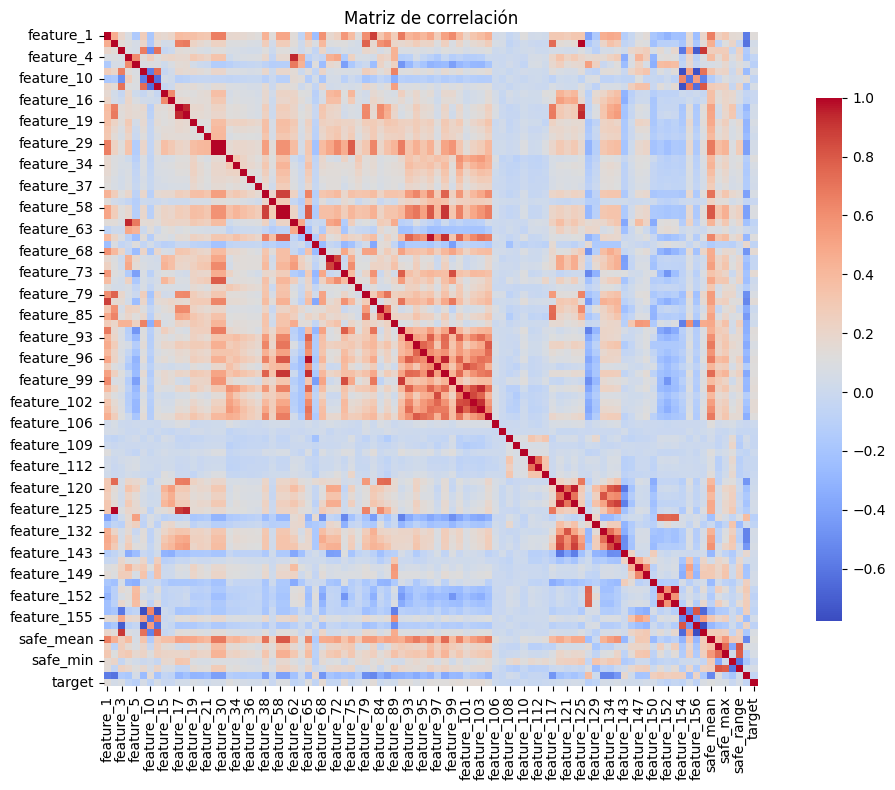


Top correlaciones con target:
target         1.000000
feature_68     0.165516
feature_73     0.164797
feature_103    0.157861
feature_102    0.152847
                 ...   
feature_113    0.010703
feature_110    0.004671
feature_106    0.004027
feature_84     0.000935
feature_117    0.000409
Name: target, Length: 91, dtype: float64


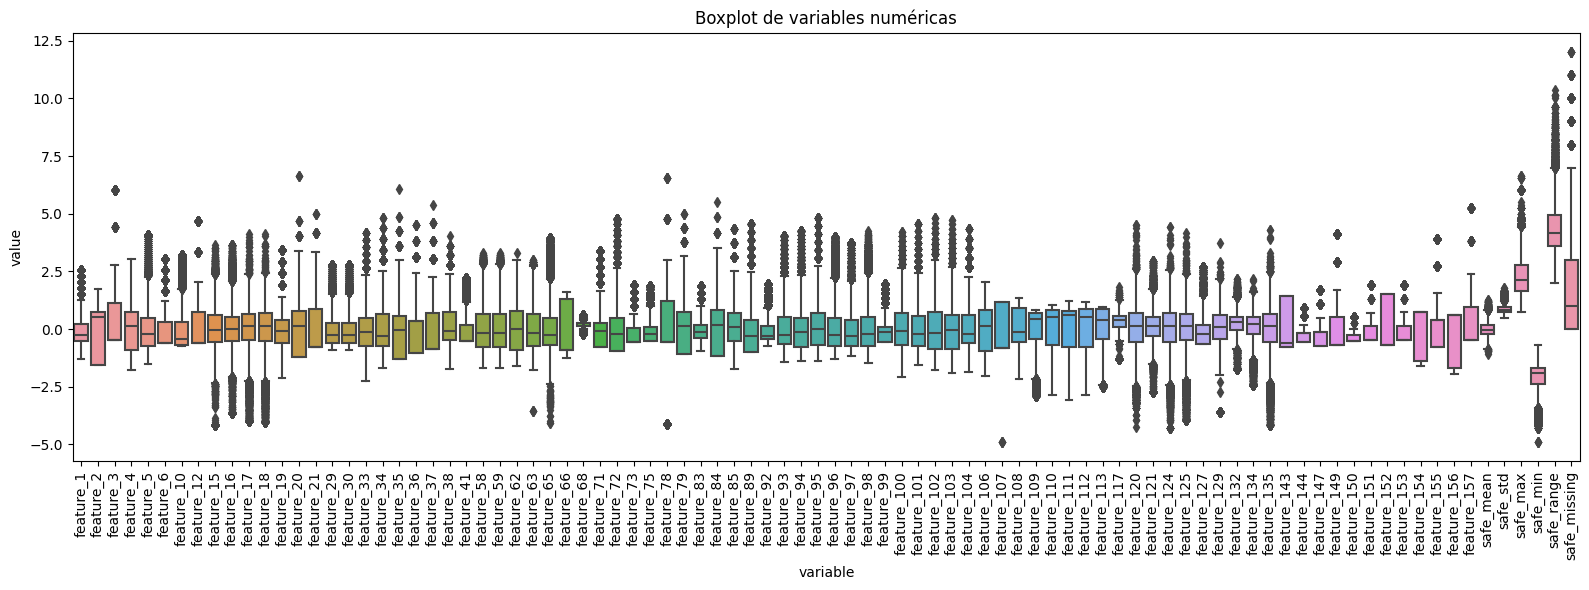

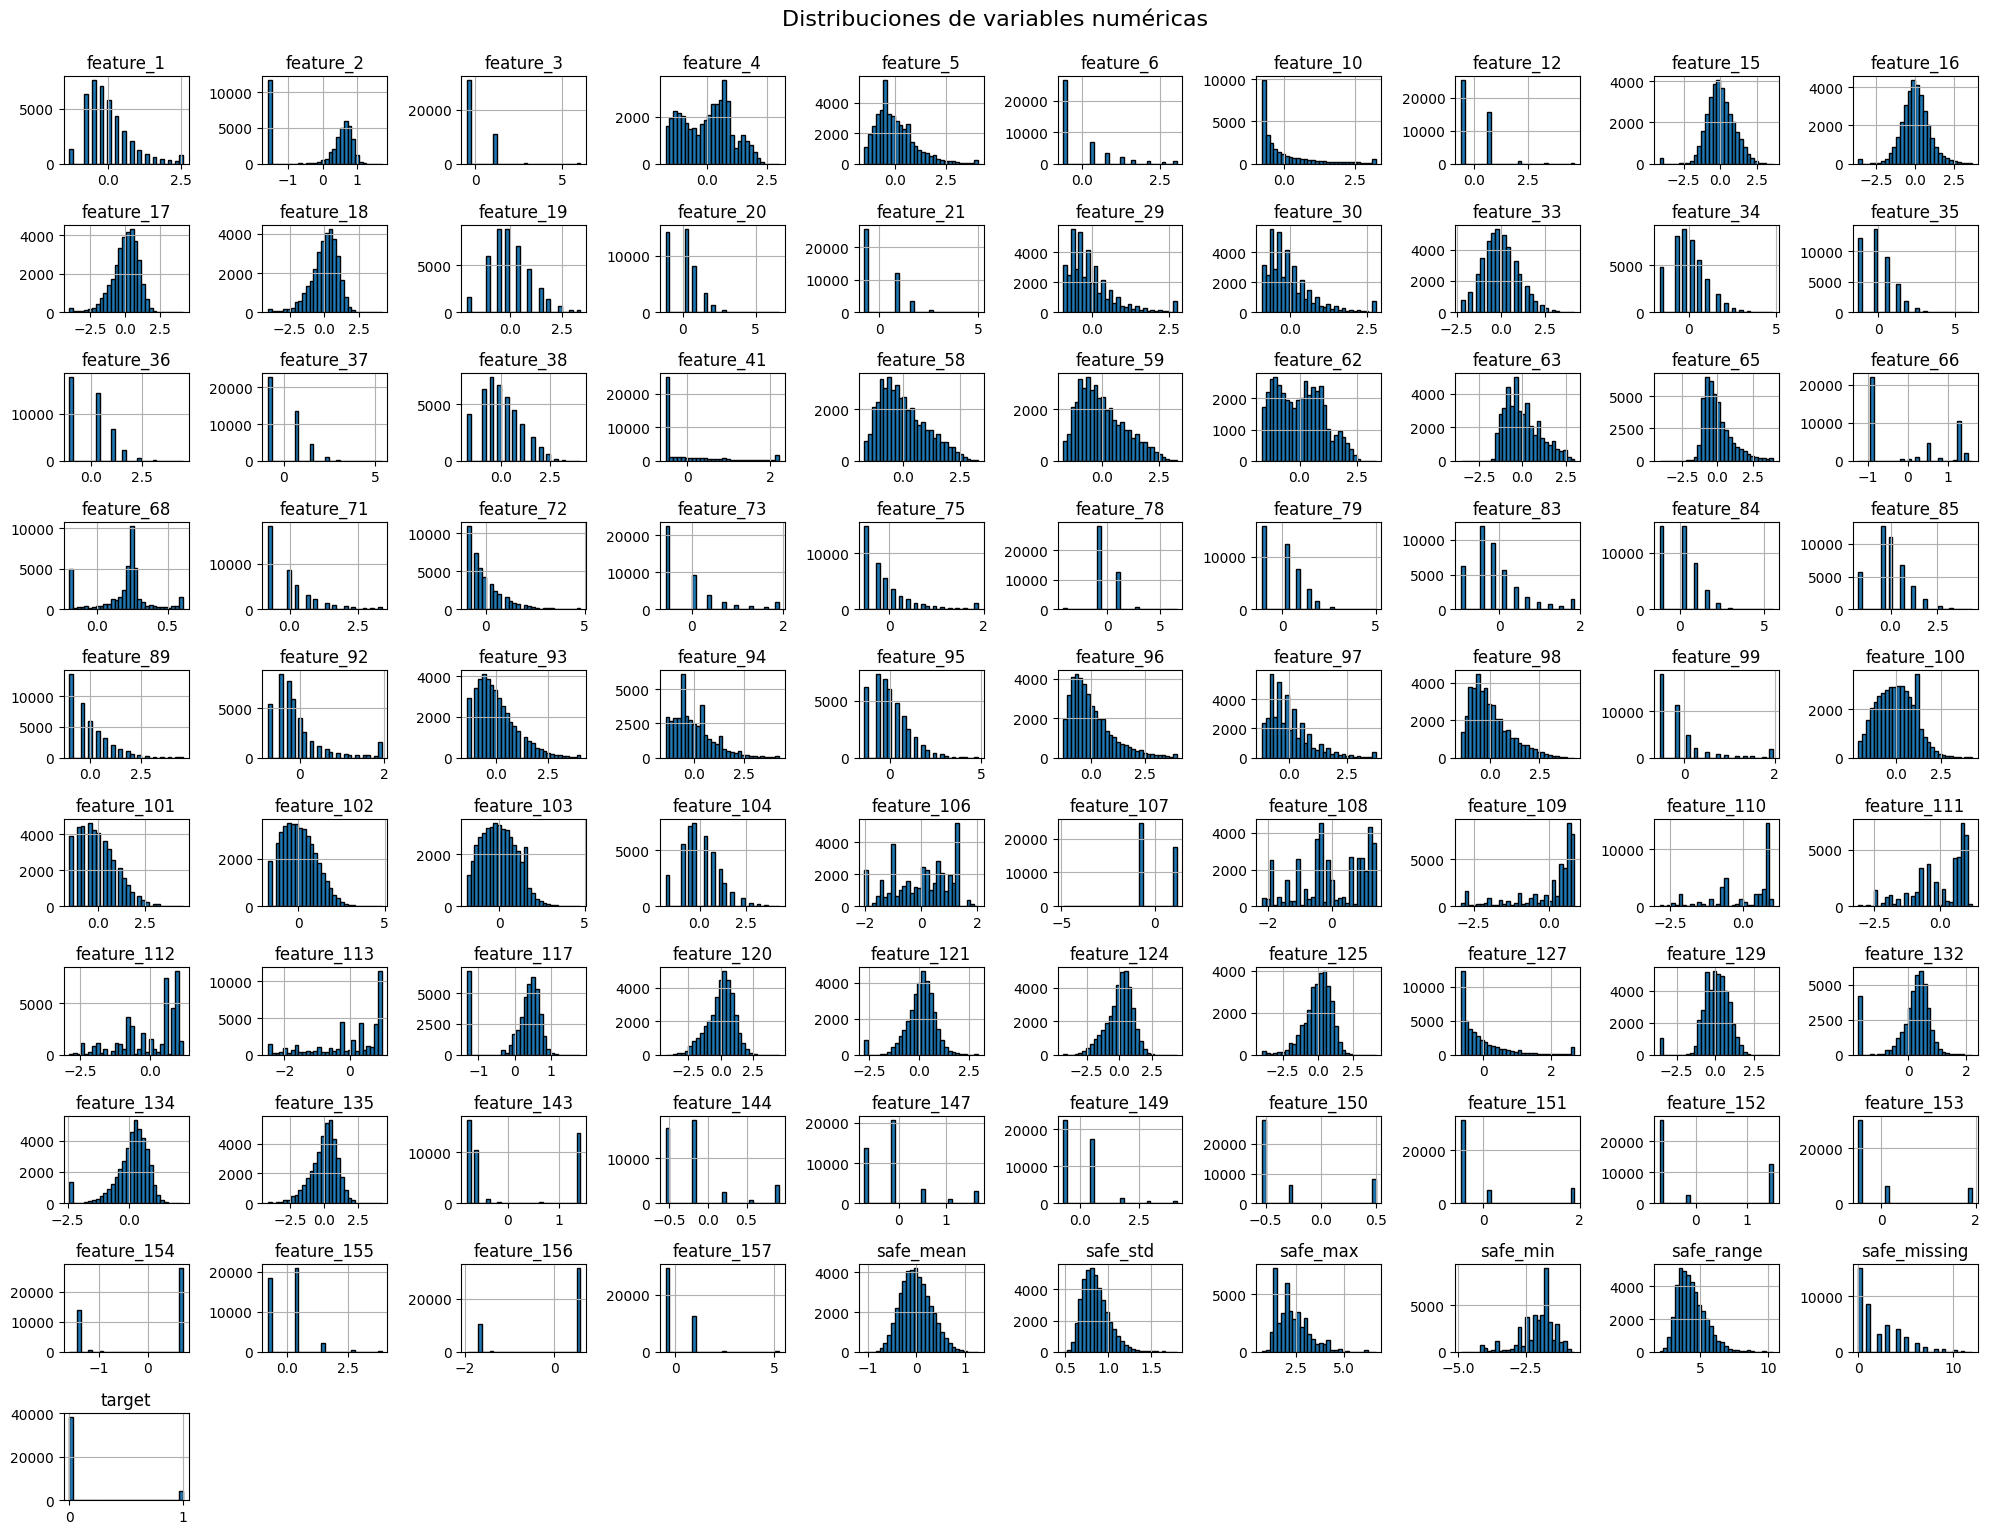

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

cor_target = df.corr()['target'].abs().sort_values(ascending=False)
print("\nTop correlaciones con target:")
print(cor_target)

plt.figure(figsize=(16, 6))
df_melted = df.drop(columns='target').melt()
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=90)
plt.title("Boxplot de variables numéricas")
plt.tight_layout()
plt.show()

df.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.tight_layout()
plt.suptitle("Distribuciones de variables numéricas", fontsize=16, y=1.02)
plt.show()

### Tried modelling with the cleaned dataset and results were not satisfactory. We will implement a more robust preprocessing pipeline.



 Model: Logistic Regression


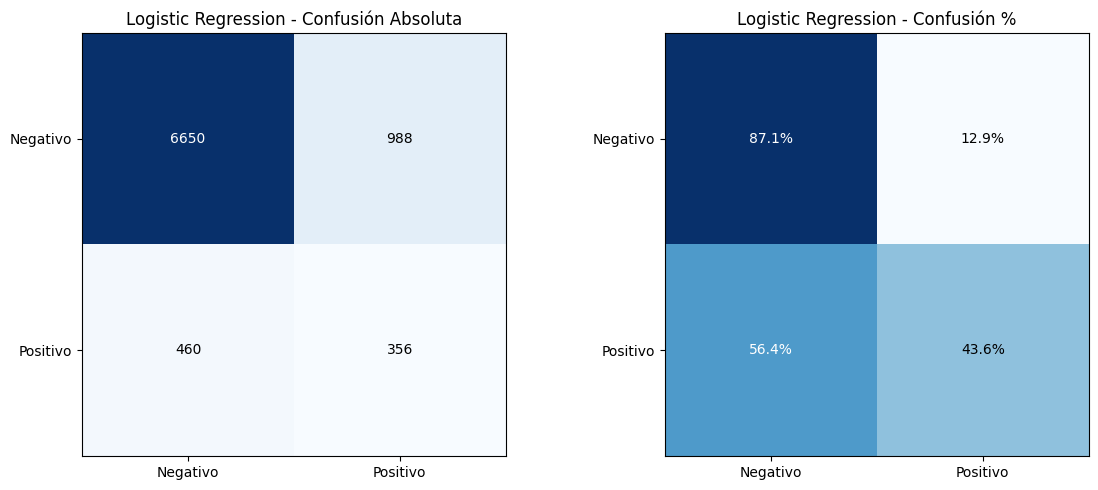

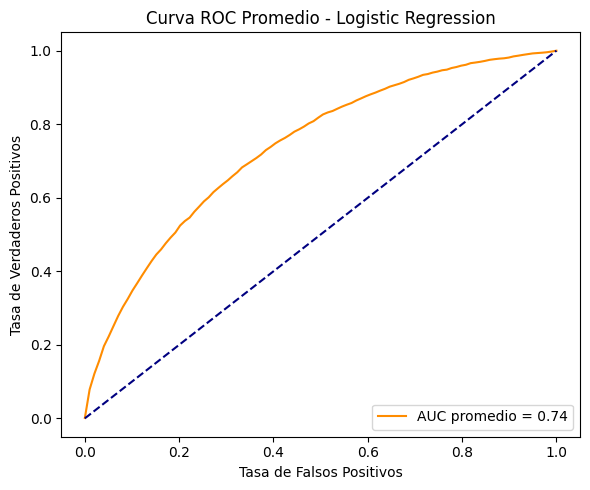


 Model: Decision Tree


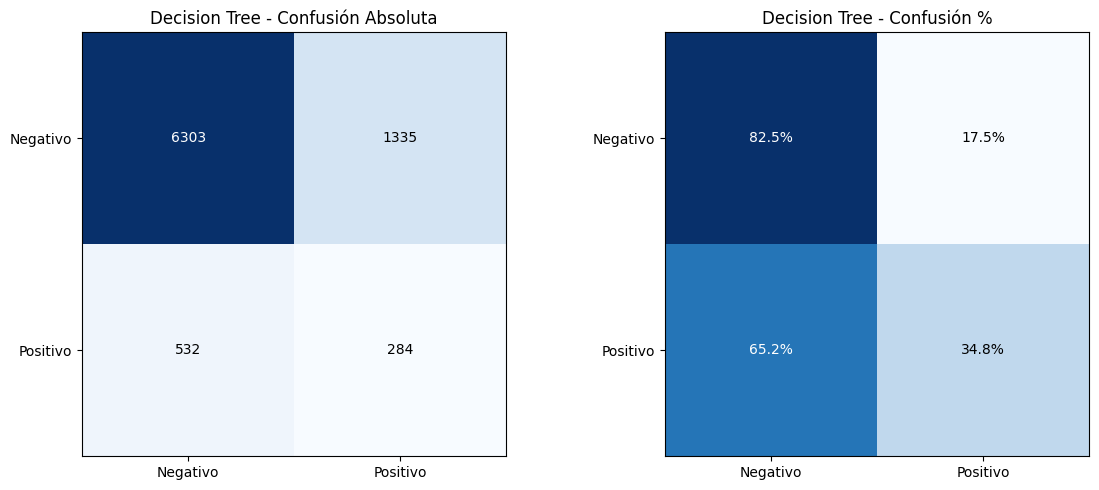

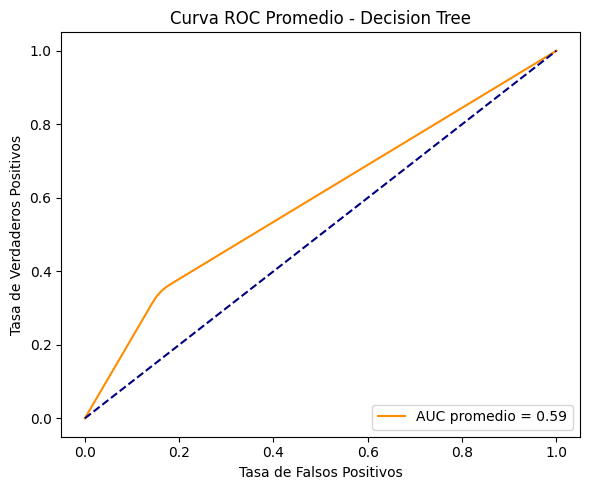


 Model: Random Forest


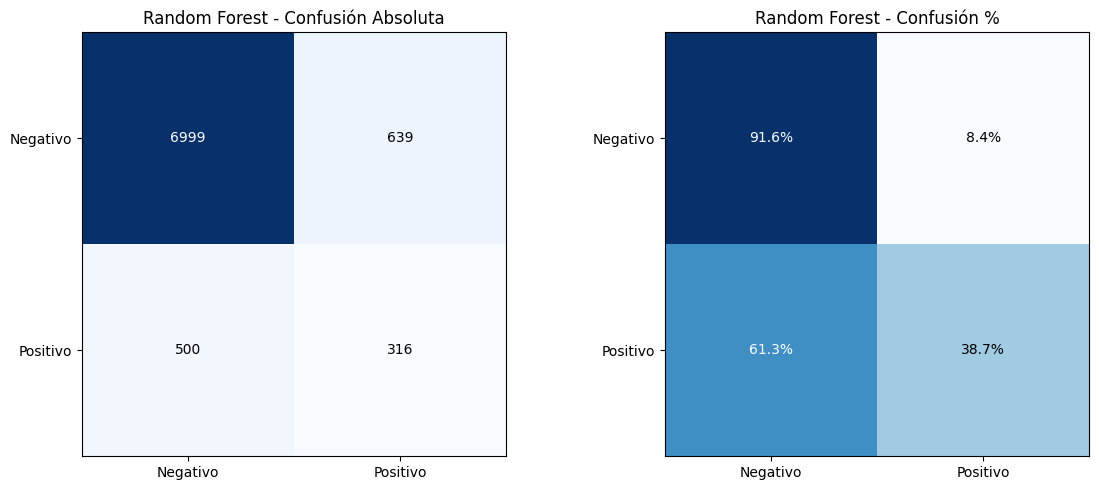

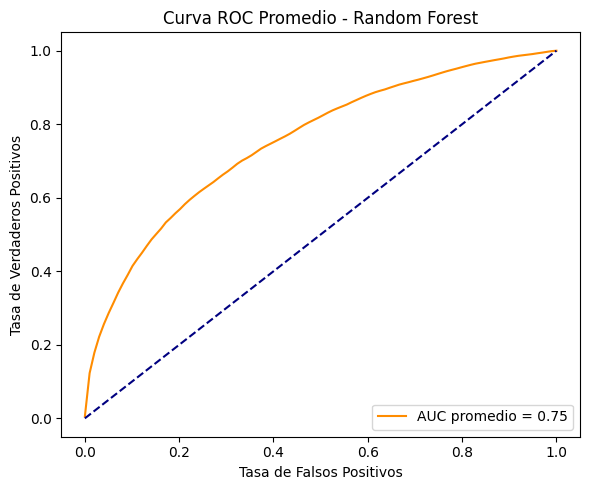


 Model: XGBoost


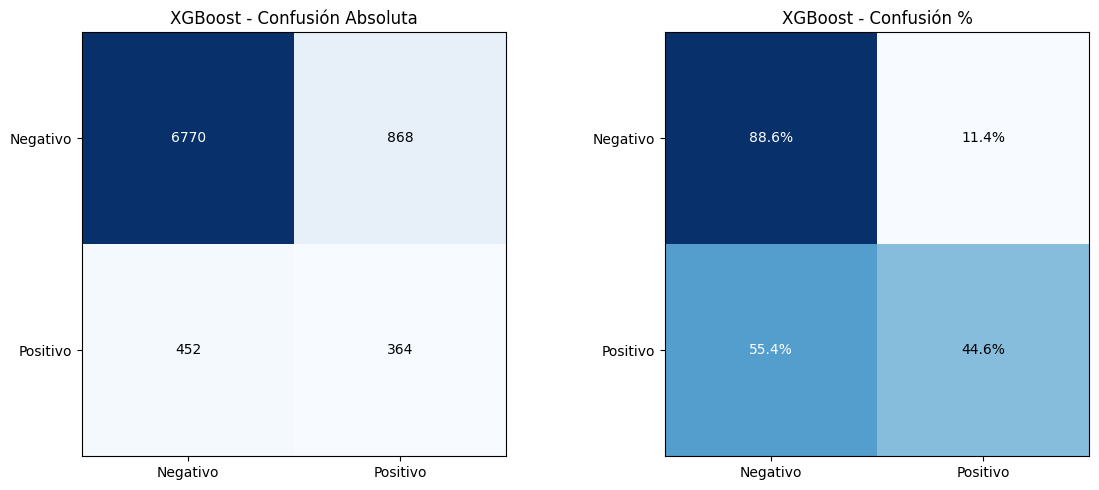

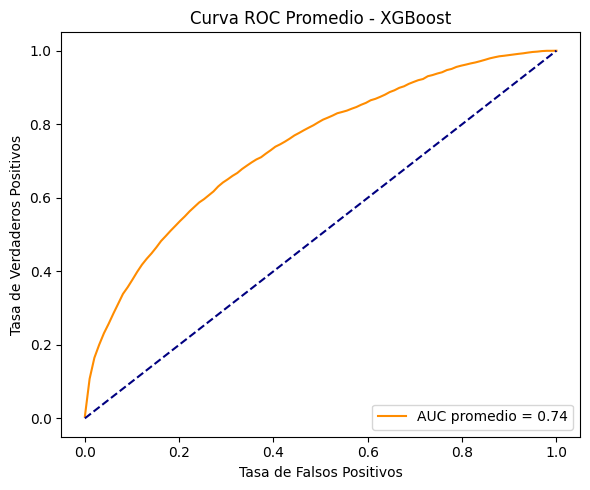


 Model: LightGBM


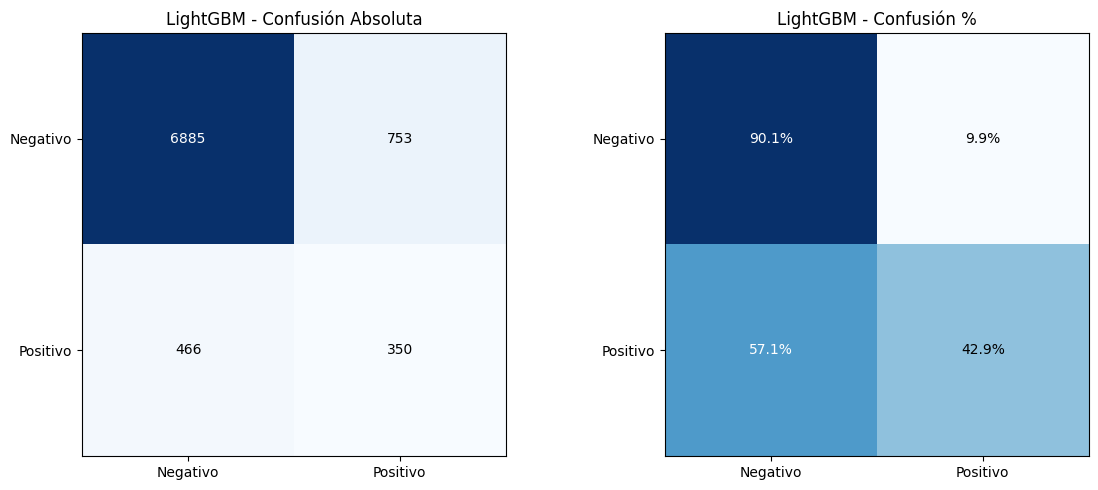

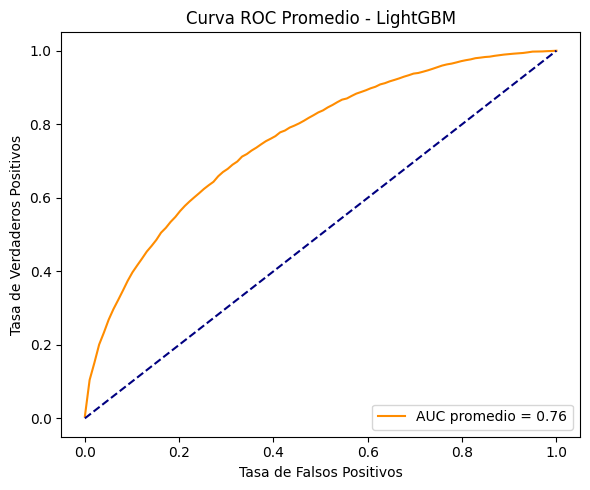


 Model: Catboost


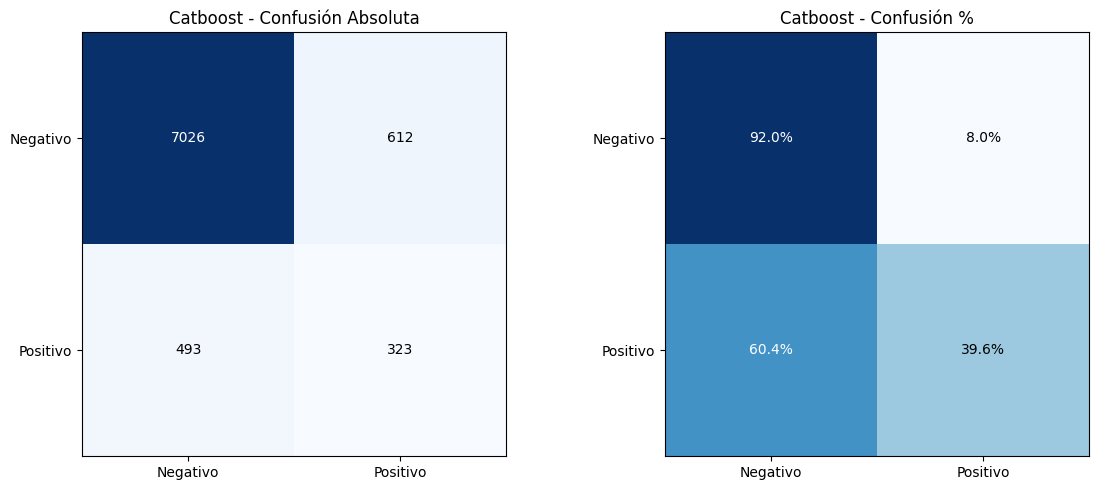

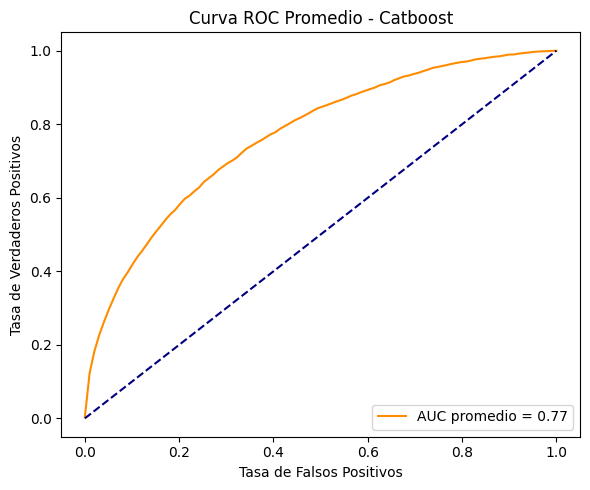


 Results per model (CV 5 folds):
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
5             Catboost  0.857238   0.320892  0.417402  0.361032  0.768290   
4             LightGBM  0.844629   0.295174  0.425980  0.346207  0.759570   
2        Random Forest  0.853122   0.309601  0.417892  0.354582  0.753498   
3              XGBoost  0.847208   0.292622  0.393873  0.332562  0.739684   
0  Logistic Regression  0.802711   0.238911  0.471814  0.316338  0.737283   
1        Decision Tree  0.793603   0.189705  0.347059  0.245162  0.594182   

     AUC-PR  Avg Threshold  
5  0.319809       0.335754  
4  0.293236       0.776802  
2  0.310692       0.398000  
3  0.287377       0.719962  
0  0.250939       0.749786  
1  0.299891       1.000000  


In [31]:
# ========== 1. LIBRERÍAS ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
)

from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# ========== 2. DATOS ==========
df = pd.read_csv("dataset.csv", header=None)
df.columns = ['id', 'sample_date', 'target'] + [f"feature_{i}" for i in range(1, df.shape[1] - 2)]
df.drop(columns=['id', 'sample_date'], inplace=True)

X = df.drop(columns="target")
y = df["target"]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

# ========== 3. MÉTRICAS ==========
def compute_metrics(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    opt_idx = np.argmax(f1)
    threshold = thresholds[opt_idx]
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "Accuracy": (y_pred == y_true).mean(),
        "Precision": precision[opt_idx],
        "Recall": recall[opt_idx],
        "F1 Score": f1[opt_idx],
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "AUC-PR": auc(recall, precision),
        "Threshold": threshold,
        "y_pred": y_pred  # para matriz
    }

# ========== 4. MODELOS ==========
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGB(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, n_jobs=-1),
    "LightGBM": LGBMClassifier(),
    "Catboost": CatBoostClassifier(verbose=0, random_state=42)
}

# ========== 5. CV + PIPELINE ==========
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados_finales = []

for nombre, modelo in modelos.items():
    print(f"\n Model: {nombre}")
    métricas = []
    fpr_list, tpr_list = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scale_pos = y_train.value_counts()[0] / y_train.value_counts()[1]
        if nombre in ["XGBoost", "LightGBM"]:
            modelo.set_params(scale_pos_weight=scale_pos)

        preprocessor = ColumnTransformer([
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median"))
            ]), num_cols),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
            ]), cat_cols)
        ])

        pipeline = ImbPipeline([
            ("prep", preprocessor),
            ("smoteenn", SMOTEENN(random_state=42)),
            ("scale", StandardScaler()),
            ("clf", modelo)
        ])

        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        metrics = compute_metrics(y_test, y_proba)
        métricas.append(metrics)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

        if fold == 4:
            cm = confusion_matrix(y_test, metrics["y_pred"])
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            ax[0].imshow(cm, cmap='Blues')
            ax[0].set_title(f"{nombre} - Confusión Absoluta")
            for i in range(2):
                for j in range(2):
                    ax[0].text(j, i, cm[i, j], ha="center", va="center",
                               color="white" if cm[i, j] > cm.max()/2 else "black")

            ax[1].imshow(cm_norm, cmap='Blues')
            ax[1].set_title(f"{nombre} - Confusión %")
            for i in range(2):
                for j in range(2):
                    ax[1].text(j, i, f"{cm_norm[i, j]:.1f}%", ha="center", va="center",
                               color="white" if cm_norm[i, j] > 50 else "black")

            for a in ax:
                a.set_xticks([0, 1])
                a.set_yticks([0, 1])
                a.set_xticklabels(["Negativo", "Positivo"])
                a.set_yticklabels(["Negativo", "Positivo"])
            plt.tight_layout()
            plt.show()

    # === ROC promedio ===
    from numpy import interp
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(fpr_list, tpr_list):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(tpr_list)
    roc_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr, mean_tpr, label=f'AUC promedio = {roc_auc:.2f}', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.title(f"Curva ROC Promedio - {nombre}")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    resultados_finales.append({
        "Model": nombre,
        "Accuracy": np.mean([m["Accuracy"] for m in métricas]),
        "Precision": np.mean([m["Precision"] for m in métricas]),
        "Recall": np.mean([m["Recall"] for m in métricas]),
        "F1 Score": np.mean([m["F1 Score"] for m in métricas]),
        "ROC AUC": np.mean([m["ROC AUC"] for m in métricas]),
        "AUC-PR": np.mean([m["AUC-PR"] for m in métricas]),
        "Avg Threshold": np.mean([m["Threshold"] for m in métricas])
    })

# ========== 6. RESULTADOS ==========
tabla_cv = pd.DataFrame(resultados_finales)
print("\n Results per model (CV 5 folds):")
print(tabla_cv.sort_values("ROC AUC", ascending=False))


## Model Selection Summary

Given the business objective of minimizing **false positives** in fraud detection (i.e., avoiding blocking legitimate transactions), I prioritized models with the highest **precision**.

After evaluating five models using 4-fold stratified cross-validation, **Catboost** was selected as the best option:

- **Precision**: 0.32 (highest among all models)
- **F1 Score**: 0.417
- **AUC-PR**: 0.319 (robust performance on imbalanced data)
- **Threshold**: 0.33 (more permissive, allowing detection of positives with confidence)

While LightGBM had slightly higher AUC-ROC, its lower precision and higher decision threshold made it less suited to our false-positive-sensitive context.

**Conclusion**: Catboost offers the best trade-off between fraud detection and false-positive control, making it the most appropriate model under our operational constraints.
